# Param search

необходимые команды в виндовс шобы все роботоло

облегчить установку на виндовс   
получить токен  
подсказок побольше  
несколько инструментов

In [ ]:
!python -m pip install grpcio

In [ ]:
!python -m pip install grpcio-tools

In [ ]:
pip install pytest_freezegun

In [ ]:
pip install --user ipykernel

In [ ]:
python -m ipykernel install --user --name=.venv

In [ ]:
!poetry run python -m scripts.download_protos

In [ ]:
!poetry run python -m grpc_tools.protoc -I protos --python_out=. --mypy_out=. --grpc_python_out=. protos/tinkoff/invest/grpc/*.proto

Imports

In [1]:
import sys
sys.path.append('C:\\Users\\Nikita\\Desktop\\PythonScripts\\algotrading\\invest-python')

In [2]:
!set PATH=%PATH%;%APPDATA%\Python\Scripts

In [3]:
import logging

from tinkoff.invest.mock_services import MockedClient
from decimal import Decimal
from tinkoff.invest.strategies.moving_average.strategy_settings import (
    MovingAverageStrategySettings,
)
from tinkoff.invest import CandleInterval, MoneyValue
from tinkoff.invest.strategies.moving_average.signal_executor import (
    MovingAverageSignalExecutor,
)
from tinkoff.invest.strategies.moving_average.supervisor import (
    MovingAverageStrategySupervisor,
)
from tinkoff.invest.strategies.moving_average.strategy_state import (
    MovingAverageStrategyState,
)
from tinkoff.invest.strategies.moving_average.strategy import MovingAverageStrategy
from tinkoff.invest.strategies.moving_average.trader import MovingAverageStrategyTrader
from datetime import timedelta, datetime, timezone
from tinkoff.invest.typedefs import ShareId, AccountId
from tinkoff.invest.strategies.base.account_manager import AccountManager
from tinkoff.invest.strategies.moving_average.plotter import (
    MovingAverageStrategyPlotter,
)


logging.basicConfig(format="%(asctime)s %(levelname)s:%(message)s", level=logging.INFO)
logger = logging.getLogger(__name__)

Setup

In [4]:
#sandbox token
token = ""

Settings

In [5]:
n, m, s = 240, 60, 30
candle_intervals = {"1min": 60, "5min":5*60}
period = 1      #func(candle_interval) - количество минут в выбранном интервале тф

#figi = ShareId("BBG004730N88")
stocks = {"AAPL":{"figi":"BBG000B9XRY4"}, "MSFT":{"figi":"BBG000BPH459"}, 
          #"GOOG":{"figi":"BBG009S3NB30"}, гугл не работает
          "AMZN":{"figi":"BBG000BVPV84"}, "TSLA":{"figi":"BBG000N9MNX3"}}

# account_id = AccountId("1337007228")
# settings = MovingAverageStrategySettings(
#     share_id=figi, #figi конкретной ценной бумаги
#     account_id=account_id, #неважно для sandbox
#     max_transaction_price=Decimal(10000), #максимальный объем сделки - зависит от размера портфеля. сейчас фиксировано
#     candle_interval=CandleInterval.CANDLE_INTERVAL_1_MIN, #тф - таймфрейм
#     long_period=timedelta(minutes= n * period), #длинная скользяшка
#     short_period=timedelta(minutes= m * period), #короткая скользяшка
#     std_period=timedelta(minutes=s * period), #количество периодов для стд
# )

Stocks for date

In [6]:
def start_datetime() -> datetime:
    return datetime(year=2022, month=2, day=1, hour=17, tzinfo=timezone.utc)

#тут надо проставлять сдвиг даты в зависимости от выбранного тф
# что-то вроде CandleInterval.CANDLE_INTERVAL_1_MIN.seconds * (m+n) для real_market_data_test_from
real_market_data_test_from = start_datetime() - timedelta(seconds = (n+m)*60) #с какой даты начинают считаться индикаторы
real_market_data_test_start = start_datetime() # с какой даты начинает работать стратегия
real_market_data_test_end = start_datetime() + timedelta(days=2) #когда все заканчивается

Initial balance

In [7]:
#balance = MoneyValue(currency="rub", units=20050, nano=690000000)

Trader

In [8]:
balances = {}

for stock in stocks:
    
    figi = ShareId(stocks[stock]["figi"])
    
    balance = MoneyValue(currency="rub", units=20050, nano=690000000)
    
    account_id = AccountId("1337007228")
    settings = MovingAverageStrategySettings(
        share_id=figi, #figi конкретной ценной бумаги
        account_id=account_id, #неважно для sandbox
        max_transaction_price=Decimal(10000), #максимальный объем сделки - зависит от размера портфеля. сейчас фиксировано
        candle_interval=CandleInterval.CANDLE_INTERVAL_1_MIN, #тф - таймфрейм
        long_period=timedelta(minutes= n * period), #длинная скользяшка
        short_period=timedelta(minutes= m * period), #короткая скользяшка
        std_period=timedelta(minutes=s * period), #количество периодов для стд
    )

    with MockedClient(
        token=token,
        settings=settings,
        real_market_data_test_from=real_market_data_test_from,
        real_market_data_test_start=real_market_data_test_start,
        real_market_data_test_end=real_market_data_test_end,
        balance=balance,
    ) as mocked_services:
        account_manager = AccountManager(
            services=mocked_services, strategy_settings=settings
        )
        state = MovingAverageStrategyState()
        strategy = MovingAverageStrategy(
            settings=settings,
            account_manager=account_manager,
            state=state,
        )
        supervisor = MovingAverageStrategySupervisor()
        signal_executor = MovingAverageSignalExecutor(
            services=mocked_services,
            state=state,
            settings=settings,
        )
        moving_average_strategy_trader = MovingAverageStrategyTrader(
            strategy=strategy,
            settings=settings,
            services=mocked_services,
            state=state,
            signal_executor=signal_executor,
            account_manager=account_manager,
            supervisor=supervisor,
        )
        plotter = MovingAverageStrategyPlotter(settings=settings)

        initial_balance = account_manager.get_current_balance()

        for i in range(50):
            logger.info("Trade %s", i)
            moving_average_strategy_trader.trade()
    
    balances[stock] = balance.units

2022-02-01 20:00:00,000 INFO:fa213f2f0387be039a53894a8264070f GetCandles
2022-02-01 20:00:00,000 INFO:6c8157868015847e67644456e5932db4 GetCandles
2022-02-01 20:00:00,000 INFO:add7b8a237a05e7815bdab257cc6bfd1 GetCandles
2022-02-01 20:00:00,000 INFO:Loading candles for period 5:00:00 from 2022-02-01 17:00:00
2022-02-01 20:00:00,000 INFO:Marginal trade is active
2022-02-01 20:00:00,000 INFO:Got enough data for strategy
2022-02-01 20:00:00,000 INFO:Trade 0
2022-02-01 20:00:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:00:00,000 INFO:Refreshing data
2022-02-01 20:00:00,000 INFO:Data refreshed
2022-02-01 20:00:00,000 INFO:Strategy predict
2022-02-01 20:00:00,000 INFO:Got signals [OpenLongMarketOrder(lots=115, direction=<SignalDirection.LONG: 'LONG'>)]
2022-02-01 20:00:00,000 INFO:Trying to execute signal OpenLongMarketOrder(lots=115, direction=<SignalDirection.LONG: 'LONG'>)
2022-02-01 20:00:00,000 WARNING:Operation: OrderDirection.ORDER_DIRECTION_BUY, -20026.10000000
2022-02-01 20:00:00

2022-02-01 20:39:00,000 INFO:Data refreshed
2022-02-01 20:39:00,000 INFO:Strategy predict
2022-02-01 20:39:00,000 INFO:Balance: 24.59000000
2022-02-01 20:39:00,000 INFO:Refreshing data
2022-02-01 20:40:00,000 INFO:Data refreshed
2022-02-01 20:40:00,000 INFO:Strategy predict
2022-02-01 20:40:00,000 INFO:Balance: 24.59000000
2022-02-01 20:40:00,000 INFO:Refreshing data
2022-02-01 20:41:00,000 INFO:Data refreshed
2022-02-01 20:41:00,000 INFO:Strategy predict
2022-02-01 20:41:00,000 INFO:Balance: 24.59000000
2022-02-01 20:41:00,000 INFO:Refreshing data
2022-02-01 20:42:00,000 INFO:Data refreshed
2022-02-01 20:42:00,000 INFO:Strategy predict
2022-02-01 20:42:00,000 INFO:Balance: 24.59000000
2022-02-01 20:42:00,000 INFO:Refreshing data
2022-02-01 20:43:00,000 INFO:Data refreshed
2022-02-01 20:43:00,000 INFO:Strategy predict
2022-02-01 20:43:00,000 INFO:Balance: 24.59000000
2022-02-01 20:43:00,000 INFO:Refreshing data
2022-02-01 20:44:00,000 INFO:Data refreshed
2022-02-01 20:44:00,000 INFO:St

2022-02-01 21:17:00,000 INFO:Refreshing data
2022-02-01 21:18:00,000 INFO:Data refreshed
2022-02-01 21:18:00,000 INFO:Strategy predict
2022-02-01 21:18:00,000 INFO:Balance: 39849.09000000
2022-02-01 21:18:00,000 INFO:Refreshing data
2022-02-01 21:19:00,000 INFO:Data refreshed
2022-02-01 21:19:00,000 INFO:Strategy predict
2022-02-01 21:19:00,000 INFO:Balance: 39849.09000000
2022-02-01 21:19:00,000 INFO:Refreshing data
2022-02-01 21:20:00,000 INFO:Data refreshed
2022-02-01 21:20:00,000 INFO:Strategy predict
2022-02-01 21:20:00,000 INFO:Balance: 39849.09000000
2022-02-01 21:20:00,000 INFO:Refreshing data
2022-02-01 21:21:00,000 INFO:Data refreshed
2022-02-01 21:21:00,000 INFO:Strategy predict
2022-02-01 21:21:00,000 INFO:Balance: 39849.09000000
2022-02-01 21:21:00,000 INFO:Refreshing data
2022-02-01 21:22:00,000 INFO:Data refreshed
2022-02-01 21:22:00,000 INFO:Strategy predict
2022-02-01 21:22:00,000 INFO:Balance: 39849.09000000
2022-02-01 21:22:00,000 INFO:Refreshing data
2022-02-01 21:2

2022-02-01 22:01:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:01:00,000 INFO:Refreshing data
2022-02-01 22:02:00,000 INFO:Data refreshed
2022-02-01 22:02:00,000 INFO:Strategy predict
2022-02-01 22:02:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:02:00,000 INFO:Refreshing data
2022-02-01 22:03:00,000 INFO:Data refreshed
2022-02-01 22:03:00,000 INFO:Strategy predict
2022-02-01 22:03:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:03:00,000 INFO:Refreshing data
2022-02-01 22:04:00,000 INFO:Data refreshed
2022-02-01 22:04:00,000 INFO:Strategy predict
2022-02-01 22:04:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:04:00,000 INFO:Refreshing data
2022-02-01 22:05:00,000 INFO:Data refreshed
2022-02-01 22:05:00,000 INFO:Strategy predict
2022-02-01 22:05:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:05:00,000 INFO:Refreshing data
2022-02-01 22:06:00,000 INFO:Data refreshed
2022-02-01 22:06:00,000 INFO:Strategy predict
2022-02-01 22:06:00,000 INFO:Balance: 39849.09000000
2022-02

2022-02-01 22:45:00,000 INFO:Strategy predict
2022-02-01 22:45:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:45:00,000 INFO:Refreshing data
2022-02-01 22:46:00,000 INFO:Data refreshed
2022-02-01 22:46:00,000 INFO:Strategy predict
2022-02-01 22:46:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:46:00,000 INFO:Refreshing data
2022-02-01 22:47:00,000 INFO:Data refreshed
2022-02-01 22:47:00,000 INFO:Strategy predict
2022-02-01 22:47:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:47:00,000 INFO:Refreshing data
2022-02-01 22:48:00,000 INFO:Data refreshed
2022-02-01 22:48:00,000 INFO:Strategy predict
2022-02-01 22:48:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:48:00,000 INFO:Refreshing data
2022-02-01 22:49:00,000 INFO:Data refreshed
2022-02-01 22:49:00,000 INFO:Strategy predict
2022-02-01 22:49:00,000 INFO:Balance: 39849.09000000
2022-02-01 22:49:00,000 INFO:Refreshing data
2022-02-01 22:50:00,000 INFO:Data refreshed
2022-02-01 22:50:00,000 INFO:Strategy predict
2022-02-01 22:

2022-02-01 23:24:00,000 INFO:Balance: -19880.93000000
2022-02-01 23:24:00,000 INFO:Refreshing data
2022-02-01 23:25:00,000 INFO:Data refreshed
2022-02-01 23:25:00,000 INFO:Strategy predict
2022-02-01 23:25:00,000 INFO:Balance: -19880.93000000
2022-02-01 23:25:00,000 INFO:Refreshing data
2022-02-01 23:26:00,000 INFO:Data refreshed
2022-02-01 23:26:00,000 INFO:Strategy predict
2022-02-01 23:26:00,000 INFO:Balance: -19880.93000000
2022-02-01 23:26:00,000 INFO:Refreshing data
2022-02-01 23:27:00,000 INFO:Data refreshed
2022-02-01 23:27:00,000 INFO:Strategy predict
2022-02-01 23:27:00,000 INFO:Balance: -19880.93000000
2022-02-01 23:27:00,000 INFO:Refreshing data
2022-02-01 23:28:00,000 INFO:Data refreshed
2022-02-01 23:28:00,000 INFO:Strategy predict
2022-02-01 23:28:00,000 INFO:Balance: -19880.93000000
2022-02-01 23:28:00,000 INFO:Refreshing data
2022-02-01 23:29:00,000 INFO:Data refreshed
2022-02-01 23:29:00,000 INFO:Strategy predict
2022-02-01 23:29:00,000 INFO:Balance: -19880.93000000
2

2022-02-02 00:08:00,000 INFO:Data refreshed
2022-02-02 00:08:00,000 INFO:Strategy predict
2022-02-02 00:08:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:08:00,000 INFO:Refreshing data
2022-02-02 00:09:00,000 INFO:Data refreshed
2022-02-02 00:09:00,000 INFO:Strategy predict
2022-02-02 00:09:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:09:00,000 INFO:Refreshing data
2022-02-02 00:10:00,000 INFO:Data refreshed
2022-02-02 00:10:00,000 INFO:Strategy predict
2022-02-02 00:10:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:10:00,000 INFO:Refreshing data
2022-02-02 00:11:00,000 INFO:Data refreshed
2022-02-02 00:11:00,000 INFO:Strategy predict
2022-02-02 00:11:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:11:00,000 INFO:Refreshing data
2022-02-02 00:12:00,000 INFO:Data refreshed
2022-02-02 00:12:00,000 INFO:Strategy predict
2022-02-02 00:12:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:12:00,000 INFO:Refreshing data
2022-02-02 00:13:00,000 INFO:Data refreshed
2022-02-02 

2022-02-02 00:51:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:51:00,000 INFO:Refreshing data
2022-02-02 00:52:00,000 INFO:Data refreshed
2022-02-02 00:52:00,000 INFO:Strategy predict
2022-02-02 00:52:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:52:00,000 INFO:Refreshing data
2022-02-02 00:53:00,000 INFO:Data refreshed
2022-02-02 00:53:00,000 INFO:Strategy predict
2022-02-02 00:53:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:53:00,000 INFO:Refreshing data
2022-02-02 00:54:00,000 INFO:Data refreshed
2022-02-02 00:54:00,000 INFO:Strategy predict
2022-02-02 00:54:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:54:00,000 INFO:Refreshing data
2022-02-02 00:55:00,000 INFO:Data refreshed
2022-02-02 00:55:00,000 INFO:Strategy predict
2022-02-02 00:55:00,000 INFO:Balance: -19880.93000000
2022-02-02 00:55:00,000 INFO:Refreshing data
2022-02-02 00:56:00,000 INFO:Data refreshed
2022-02-02 00:56:00,000 INFO:Strategy predict
2022-02-02 00:56:00,000 INFO:Balance: -19880.93000000
2

2022-02-02 01:35:00,000 INFO:Data refreshed
2022-02-02 01:35:00,000 INFO:Strategy predict
2022-02-02 01:35:00,000 INFO:Balance: -19880.93000000
2022-02-02 01:35:00,000 INFO:Refreshing data
2022-02-02 01:36:00,000 INFO:Data refreshed
2022-02-02 01:36:00,000 INFO:Strategy predict
2022-02-02 01:36:00,000 INFO:Balance: -19880.93000000
2022-02-02 01:36:00,000 INFO:Refreshing data
2022-02-02 01:37:00,000 INFO:Data refreshed
2022-02-02 01:37:00,000 INFO:Strategy predict
2022-02-02 01:37:00,000 INFO:Balance: -19880.93000000
2022-02-02 01:37:00,000 INFO:Refreshing data
2022-02-02 01:38:00,000 INFO:Data refreshed
2022-02-02 01:38:00,000 INFO:Strategy predict
2022-02-02 01:38:00,000 INFO:Balance: -19880.93000000
2022-02-02 01:38:00,000 INFO:Refreshing data
2022-02-02 01:39:00,000 INFO:Data refreshed
2022-02-02 01:39:00,000 INFO:Strategy predict
2022-02-02 01:39:00,000 INFO:Balance: -19880.93000000
2022-02-02 01:39:00,000 INFO:Refreshing data
2022-02-02 01:40:00,000 INFO:Data refreshed
2022-02-02 

2022-02-02 02:15:00,000 INFO:Balance: 19971.19000000
2022-02-02 02:15:00,000 INFO:Refreshing data
2022-02-02 02:16:00,000 INFO:Data refreshed
2022-02-02 02:16:00,000 INFO:Strategy predict
2022-02-02 02:16:00,000 INFO:Strategy run complete
2022-02-02 02:16:00,000 INFO:Trade 3
2022-02-02 02:16:00,000 INFO:Balance: 19971.19000000
2022-02-02 02:16:00,000 INFO:Refreshing data
2022-02-02 02:17:00,000 INFO:Data refreshed
2022-02-02 02:17:00,000 INFO:Strategy predict
2022-02-02 02:17:00,000 INFO:Strategy run complete
2022-02-02 02:17:00,000 INFO:Trade 4
2022-02-02 02:17:00,000 INFO:Balance: 19971.19000000
2022-02-02 02:17:00,000 INFO:Refreshing data
2022-02-02 02:18:00,000 INFO:Data refreshed
2022-02-02 02:18:00,000 INFO:Strategy predict
2022-02-02 02:18:00,000 INFO:Strategy run complete
2022-02-02 02:18:00,000 INFO:Trade 5
2022-02-02 02:18:00,000 INFO:Balance: 19971.19000000
2022-02-02 02:18:00,000 INFO:Refreshing data
2022-02-02 02:19:00,000 INFO:Data refreshed
2022-02-02 02:19:00,000 INFO:S

2022-02-02 02:47:00,000 INFO:Data refreshed
2022-02-02 02:47:00,000 INFO:Strategy predict
2022-02-02 02:47:00,000 INFO:Balance: 43.99000000
2022-02-02 02:47:00,000 INFO:Refreshing data
2022-02-02 02:48:00,000 INFO:Data refreshed
2022-02-02 02:48:00,000 INFO:Strategy predict
2022-02-02 02:48:00,000 INFO:Balance: 43.99000000
2022-02-02 02:48:00,000 INFO:Refreshing data
2022-02-02 02:49:00,000 INFO:Data refreshed
2022-02-02 02:49:00,000 INFO:Strategy predict
2022-02-02 02:49:00,000 INFO:Balance: 43.99000000
2022-02-02 02:49:00,000 INFO:Refreshing data
2022-02-02 02:50:00,000 INFO:Data refreshed
2022-02-02 02:50:00,000 INFO:Strategy predict
2022-02-02 02:50:00,000 INFO:Balance: 43.99000000
2022-02-02 02:50:00,000 INFO:Refreshing data
2022-02-02 02:51:00,000 INFO:Data refreshed
2022-02-02 02:51:00,000 INFO:Strategy predict
2022-02-02 02:51:00,000 INFO:Balance: 43.99000000
2022-02-02 02:51:00,000 INFO:Refreshing data
2022-02-02 02:52:00,000 INFO:Data refreshed
2022-02-02 02:52:00,000 INFO:St

2022-02-02 03:31:00,000 INFO:Balance: 43.99000000
2022-02-02 03:31:00,000 INFO:Refreshing data
2022-02-02 03:32:00,000 INFO:Data refreshed
2022-02-02 03:32:00,000 INFO:Strategy predict
2022-02-02 03:32:00,000 INFO:Balance: 43.99000000
2022-02-02 03:32:00,000 INFO:Refreshing data
2022-02-02 03:33:00,000 INFO:Data refreshed
2022-02-02 03:33:00,000 INFO:Strategy predict
2022-02-02 03:33:00,000 INFO:Balance: 43.99000000
2022-02-02 03:33:00,000 INFO:Refreshing data
2022-02-02 03:34:00,000 INFO:Data refreshed
2022-02-02 03:34:00,000 INFO:Strategy predict
2022-02-02 03:34:00,000 INFO:Balance: 43.99000000
2022-02-02 03:34:00,000 INFO:Refreshing data
2022-02-02 03:35:00,000 INFO:Data refreshed
2022-02-02 03:35:00,000 INFO:Strategy predict
2022-02-02 03:35:00,000 INFO:Balance: 43.99000000
2022-02-02 03:35:00,000 INFO:Refreshing data
2022-02-02 03:36:00,000 INFO:Data refreshed
2022-02-02 03:36:00,000 INFO:Strategy predict
2022-02-02 03:36:00,000 INFO:Balance: 43.99000000
2022-02-02 03:36:00,000 I

2022-02-02 04:16:00,000 INFO:Data refreshed
2022-02-02 04:16:00,000 INFO:Strategy predict
2022-02-02 04:16:00,000 INFO:Balance: 43.99000000
2022-02-02 04:16:00,000 INFO:Refreshing data
2022-02-02 04:17:00,000 INFO:Data refreshed
2022-02-02 04:17:00,000 INFO:Strategy predict
2022-02-02 04:17:00,000 INFO:Balance: 43.99000000
2022-02-02 04:17:00,000 INFO:Refreshing data
2022-02-02 04:18:00,000 INFO:Data refreshed
2022-02-02 04:18:00,000 INFO:Strategy predict
2022-02-02 04:18:00,000 INFO:Balance: 43.99000000
2022-02-02 04:18:00,000 INFO:Refreshing data
2022-02-02 04:19:00,000 INFO:Data refreshed
2022-02-02 04:19:00,000 INFO:Strategy predict
2022-02-02 04:19:00,000 INFO:Balance: 43.99000000
2022-02-02 04:19:00,000 INFO:Refreshing data
2022-02-02 04:20:00,000 INFO:Data refreshed
2022-02-02 04:20:00,000 INFO:Strategy predict
2022-02-02 04:20:00,000 INFO:Balance: 43.99000000
2022-02-02 04:20:00,000 INFO:Refreshing data
2022-02-02 04:21:00,000 INFO:Data refreshed
2022-02-02 04:21:00,000 INFO:St

2022-02-02 05:00:00,000 INFO:Balance: 43.99000000
2022-02-02 05:00:00,000 INFO:Refreshing data
2022-02-02 05:01:00,000 INFO:Data refreshed
2022-02-02 05:01:00,000 INFO:Strategy predict
2022-02-02 05:01:00,000 INFO:Balance: 43.99000000
2022-02-02 05:01:00,000 INFO:Refreshing data
2022-02-02 05:02:00,000 INFO:Data refreshed
2022-02-02 05:02:00,000 INFO:Strategy predict
2022-02-02 05:02:00,000 INFO:Balance: 43.99000000
2022-02-02 05:02:00,000 INFO:Refreshing data
2022-02-02 05:03:00,000 INFO:Data refreshed
2022-02-02 05:03:00,000 INFO:Strategy predict
2022-02-02 05:03:00,000 INFO:Balance: 43.99000000
2022-02-02 05:03:00,000 INFO:Refreshing data
2022-02-02 05:04:00,000 INFO:Data refreshed
2022-02-02 05:04:00,000 INFO:Strategy predict
2022-02-02 05:04:00,000 INFO:Balance: 43.99000000
2022-02-02 05:04:00,000 INFO:Refreshing data
2022-02-02 05:05:00,000 INFO:Data refreshed
2022-02-02 05:05:00,000 INFO:Strategy predict
2022-02-02 05:05:00,000 INFO:Balance: 43.99000000
2022-02-02 05:05:00,000 I

2022-02-02 05:45:00,000 INFO:Data refreshed
2022-02-02 05:45:00,000 INFO:Strategy predict
2022-02-02 05:45:00,000 INFO:Balance: 43.99000000
2022-02-02 05:45:00,000 INFO:Refreshing data
2022-02-02 05:46:00,000 INFO:Data refreshed
2022-02-02 05:46:00,000 INFO:Strategy predict
2022-02-02 05:46:00,000 INFO:Balance: 43.99000000
2022-02-02 05:46:00,000 INFO:Refreshing data
2022-02-02 05:47:00,000 INFO:Data refreshed
2022-02-02 05:47:00,000 INFO:Strategy predict
2022-02-02 05:47:00,000 INFO:Balance: 43.99000000
2022-02-02 05:47:00,000 INFO:Refreshing data
2022-02-02 05:48:00,000 INFO:Data refreshed
2022-02-02 05:48:00,000 INFO:Strategy predict
2022-02-02 05:48:00,000 INFO:Balance: 43.99000000
2022-02-02 05:48:00,000 INFO:Refreshing data
2022-02-02 05:49:00,000 INFO:Data refreshed
2022-02-02 05:49:00,000 INFO:Strategy predict
2022-02-02 05:49:00,000 INFO:Balance: 43.99000000
2022-02-02 05:49:00,000 INFO:Refreshing data
2022-02-02 05:50:00,000 INFO:Data refreshed
2022-02-02 05:50:00,000 INFO:St

2022-02-02 06:29:00,000 INFO:Got signals [CloseLongMarketOrder(lots=114, direction=<SignalDirection.LONG: 'LONG'>)]
2022-02-02 06:29:00,000 INFO:Trying to execute signal CloseLongMarketOrder(lots=114, direction=<SignalDirection.LONG: 'LONG'>)
2022-02-02 06:29:00,000 WARNING:Operation: OrderDirection.ORDER_DIRECTION_SELL, 19871.34000000
2022-02-02 06:29:00,000 INFO:Signal executed CloseLongMarketOrder(lots=114, direction=<SignalDirection.LONG: 'LONG'>)
2022-02-02 06:29:00,000 INFO:Strategy run complete
2022-02-02 06:29:00,000 INFO:Trade 24
2022-02-02 06:29:00,000 INFO:Balance: 19915.33000000
2022-02-02 06:29:00,000 INFO:Refreshing data
2022-02-02 06:30:00,000 INFO:Data refreshed
2022-02-02 06:30:00,000 INFO:Strategy predict
2022-02-02 06:30:00,000 INFO:Strategy run complete
2022-02-02 06:30:00,000 INFO:Trade 25
2022-02-02 06:30:00,000 INFO:Balance: 19915.33000000
2022-02-02 06:30:00,000 INFO:Refreshing data
2022-02-02 06:31:00,000 INFO:Data refreshed
2022-02-02 06:31:00,000 INFO:Strateg

2022-02-01 20:00:00,000 INFO:Refreshing data
2022-02-01 20:00:00,000 INFO:Data refreshed
2022-02-01 20:00:00,000 INFO:Strategy predict
2022-02-01 20:00:00,000 INFO:Strategy run complete
2022-02-01 20:00:00,000 INFO:Trade 1
2022-02-01 20:00:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:00:00,000 INFO:Refreshing data
2022-02-01 20:01:00,000 INFO:Data refreshed
2022-02-01 20:01:00,000 INFO:Strategy predict
2022-02-01 20:01:00,000 INFO:Strategy run complete
2022-02-01 20:01:00,000 INFO:Trade 2
2022-02-01 20:01:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:01:00,000 INFO:Refreshing data
2022-02-01 20:02:00,000 INFO:Data refreshed
2022-02-01 20:02:00,000 INFO:Strategy predict
2022-02-01 20:02:00,000 INFO:Strategy run complete
2022-02-01 20:02:00,000 INFO:Trade 3
2022-02-01 20:02:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:02:00,000 INFO:Refreshing data
2022-02-01 20:03:00,000 INFO:Data refreshed
2022-02-01 20:03:00,000 INFO:Strategy predict
2022-02-01 20:03:00,000 INFO:Strategy

2022-02-01 20:29:00,000 INFO:Trade 30
2022-02-01 20:29:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:29:00,000 INFO:Refreshing data
2022-02-01 20:30:00,000 INFO:Data refreshed
2022-02-01 20:30:00,000 INFO:Strategy predict
2022-02-01 20:30:00,000 INFO:Strategy run complete
2022-02-01 20:30:00,000 INFO:Trade 31
2022-02-01 20:30:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:30:00,000 INFO:Refreshing data
2022-02-01 20:31:00,000 INFO:Data refreshed
2022-02-01 20:31:00,000 INFO:Strategy predict
2022-02-01 20:31:00,000 INFO:Strategy run complete
2022-02-01 20:31:00,000 INFO:Trade 32
2022-02-01 20:31:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:31:00,000 INFO:Refreshing data
2022-02-01 20:32:00,000 INFO:Data refreshed
2022-02-01 20:32:00,000 INFO:Strategy predict
2022-02-01 20:32:00,000 INFO:Strategy run complete
2022-02-01 20:32:00,000 INFO:Trade 33
2022-02-01 20:32:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:32:00,000 INFO:Refreshing data
2022-02-01 20:33:00,000 INFO:Data

2022-02-01 23:14:00,000 INFO:Strategy predict
2022-02-01 23:14:00,000 INFO:Balance: -15942.71000000
2022-02-01 23:14:00,000 INFO:Refreshing data
2022-02-01 23:15:00,000 INFO:Data refreshed
2022-02-01 23:15:00,000 INFO:Strategy predict
2022-02-01 23:15:00,000 INFO:Balance: -15942.71000000
2022-02-01 23:15:00,000 INFO:Refreshing data
2022-02-01 23:16:00,000 INFO:Data refreshed
2022-02-01 23:16:00,000 INFO:Strategy predict
2022-02-01 23:16:00,000 INFO:Balance: -15942.71000000
2022-02-01 23:16:00,000 INFO:Refreshing data
2022-02-01 23:17:00,000 INFO:Data refreshed
2022-02-01 23:17:00,000 INFO:Strategy predict
2022-02-01 23:17:00,000 INFO:Balance: -15942.71000000
2022-02-01 23:17:00,000 INFO:Refreshing data
2022-02-01 23:18:00,000 INFO:Data refreshed
2022-02-01 23:18:00,000 INFO:Strategy predict
2022-02-01 23:18:00,000 INFO:Balance: -15942.71000000
2022-02-01 23:18:00,000 INFO:Refreshing data
2022-02-01 23:19:00,000 INFO:Data refreshed
2022-02-01 23:19:00,000 INFO:Strategy predict
2022-02-0

2022-02-01 23:57:00,000 INFO:Refreshing data
2022-02-01 23:58:00,000 INFO:Data refreshed
2022-02-01 23:58:00,000 INFO:Strategy predict
2022-02-01 23:58:00,000 INFO:Balance: -15942.71000000
2022-02-01 23:58:00,000 INFO:Refreshing data
2022-02-01 23:59:00,000 INFO:Data refreshed
2022-02-01 23:59:00,000 INFO:Strategy predict
2022-02-01 23:59:00,000 INFO:Balance: -15942.71000000
2022-02-01 23:59:00,000 INFO:Refreshing data
2022-02-02 00:00:00,000 INFO:Data refreshed
2022-02-02 00:00:00,000 INFO:Strategy predict
2022-02-02 00:00:00,000 INFO:Balance: -15942.71000000
2022-02-02 00:00:00,000 INFO:Refreshing data
2022-02-02 00:01:00,000 INFO:Data refreshed
2022-02-02 00:01:00,000 INFO:Strategy predict
2022-02-02 00:01:00,000 INFO:Balance: -15942.71000000
2022-02-02 00:01:00,000 INFO:Refreshing data
2022-02-02 00:02:00,000 INFO:Data refreshed
2022-02-02 00:02:00,000 INFO:Strategy predict
2022-02-02 00:02:00,000 INFO:Balance: -15942.71000000
2022-02-02 00:02:00,000 INFO:Refreshing data
2022-02-02

2022-02-02 00:39:00,000 INFO:Signal executed CloseLongMarketOrder(lots=12, direction=<SignalDirection.LONG: 'LONG'>)
2022-02-02 00:39:00,000 INFO:Strategy run complete
2022-02-02 00:39:00,000 INFO:Trade 15
2022-02-02 00:39:00,000 INFO:Balance: 21017.29000000
2022-02-02 00:39:00,000 INFO:Refreshing data
2022-02-02 00:40:00,000 INFO:Data refreshed
2022-02-02 00:40:00,000 INFO:Strategy predict
2022-02-02 00:40:00,000 INFO:Got signals [OpenLongMarketOrder(lots=6, direction=<SignalDirection.LONG: 'LONG'>)]
2022-02-02 00:40:00,000 INFO:Trying to execute signal OpenLongMarketOrder(lots=6, direction=<SignalDirection.LONG: 'LONG'>)
2022-02-02 00:40:00,000 WARNING:Operation: OrderDirection.ORDER_DIRECTION_BUY, -18468.72000000
2022-02-02 00:40:00,000 INFO:Signal executed OpenLongMarketOrder(lots=6, direction=<SignalDirection.LONG: 'LONG'>)
2022-02-02 00:40:00,000 INFO:Balance: 2548.57000000
2022-02-02 00:40:00,000 INFO:Refreshing data
2022-02-02 00:41:00,000 INFO:Data refreshed
2022-02-02 00:41:0

2022-02-02 00:54:00,000 INFO:Data refreshed
2022-02-02 00:54:00,000 INFO:Strategy predict
2022-02-02 00:54:00,000 INFO:Strategy run complete
2022-02-02 00:54:00,000 INFO:Trade 25
2022-02-02 00:54:00,000 INFO:Balance: 21011.65000000
2022-02-02 00:54:00,000 INFO:Refreshing data
2022-02-02 00:55:00,000 INFO:Data refreshed
2022-02-02 00:55:00,000 INFO:Strategy predict
2022-02-02 00:55:00,000 INFO:Strategy run complete
2022-02-02 00:55:00,000 INFO:Trade 26
2022-02-02 00:55:00,000 INFO:Balance: 21011.65000000
2022-02-02 00:55:00,000 INFO:Refreshing data
2022-02-02 00:56:00,000 INFO:Data refreshed
2022-02-02 00:56:00,000 INFO:Strategy predict
2022-02-02 00:56:00,000 INFO:Strategy run complete
2022-02-02 00:56:00,000 INFO:Trade 27
2022-02-02 00:56:00,000 INFO:Balance: 21011.65000000
2022-02-02 00:56:00,000 INFO:Refreshing data
2022-02-02 00:57:00,000 INFO:Data refreshed
2022-02-02 00:57:00,000 INFO:Strategy predict
2022-02-02 00:57:00,000 INFO:Strategy run complete
2022-02-02 00:57:00,000 INFO

2022-02-01 20:02:00,000 INFO:Strategy predict
2022-02-01 20:02:00,000 INFO:Strategy run complete
2022-02-01 20:02:00,000 INFO:Trade 3
2022-02-01 20:02:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:02:00,000 INFO:Refreshing data
2022-02-01 20:03:00,000 INFO:Data refreshed
2022-02-01 20:03:00,000 INFO:Strategy predict
2022-02-01 20:03:00,000 INFO:Strategy run complete
2022-02-01 20:03:00,000 INFO:Trade 4
2022-02-01 20:03:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:03:00,000 INFO:Refreshing data
2022-02-01 20:04:00,000 INFO:Data refreshed
2022-02-01 20:04:00,000 INFO:Strategy predict
2022-02-01 20:04:00,000 INFO:Strategy run complete
2022-02-01 20:04:00,000 INFO:Trade 5
2022-02-01 20:04:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:04:00,000 INFO:Refreshing data
2022-02-01 20:05:00,000 INFO:Data refreshed
2022-02-01 20:05:00,000 INFO:Strategy predict
2022-02-01 20:05:00,000 INFO:Strategy run complete
2022-02-01 20:05:00,000 INFO:Trade 6
2022-02-01 20:05:00,000 INFO:Balance: 

2022-02-01 20:31:00,000 INFO:Refreshing data
2022-02-01 20:32:00,000 INFO:Data refreshed
2022-02-01 20:32:00,000 INFO:Strategy predict
2022-02-01 20:32:00,000 INFO:Strategy run complete
2022-02-01 20:32:00,000 INFO:Trade 33
2022-02-01 20:32:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:32:00,000 INFO:Refreshing data
2022-02-01 20:33:00,000 INFO:Data refreshed
2022-02-01 20:33:00,000 INFO:Strategy predict
2022-02-01 20:33:00,000 INFO:Strategy run complete
2022-02-01 20:33:00,000 INFO:Trade 34
2022-02-01 20:33:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:33:00,000 INFO:Refreshing data
2022-02-01 20:34:00,000 INFO:Data refreshed
2022-02-01 20:34:00,000 INFO:Strategy predict
2022-02-01 20:34:00,000 INFO:Strategy run complete
2022-02-01 20:34:00,000 INFO:Trade 35
2022-02-01 20:34:00,000 INFO:Balance: 20050.69000000
2022-02-01 20:34:00,000 INFO:Refreshing data
2022-02-01 20:35:00,000 INFO:Data refreshed
2022-02-01 20:35:00,000 INFO:Strategy predict
2022-02-01 20:35:00,000 INFO:Strat

In [ ]:
best_stock = max(balances, key=balances.get)
best_stock

In [ ]:
balances

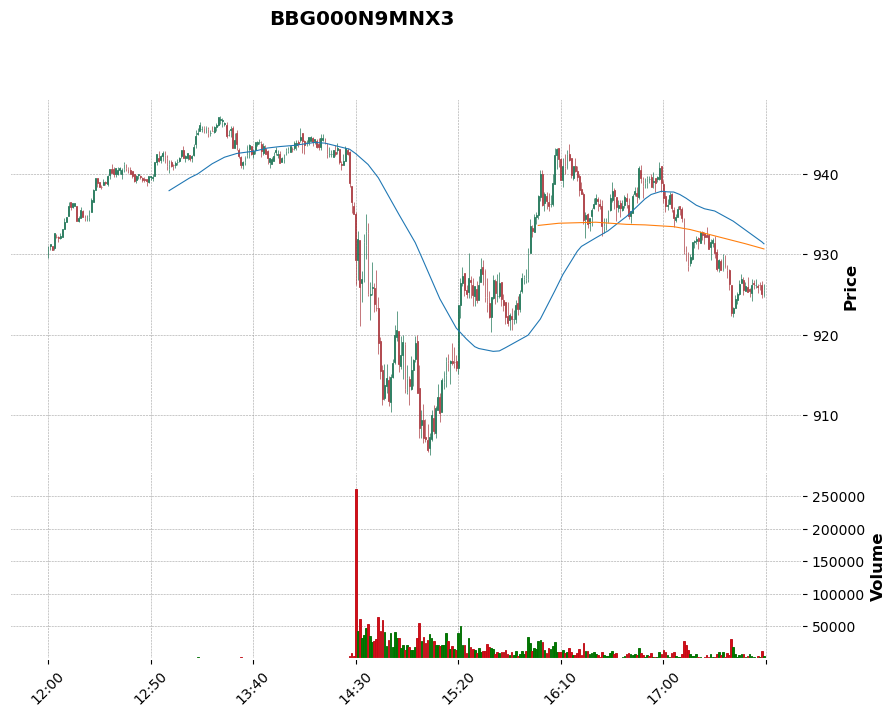

In [10]:
events = supervisor.get_events()
plotter.plot(events)

current_balance = account_manager.get_current_balance()
#assert initial_balance != current_balance
#logger.info("Initial balance %s", initial_balance)
#logger.info("Current balance %s", current_balance)

In [ ]:
logger.debug.

In [ ]:
import numpy as np

In [ ]:
test_prices = [150, 151, 152, 148,147,145,145,146,144,150]

In [ ]:
np.std(test_prices, axis=0)

In [ ]:
logger.debug.